In [1]:


from PIL import Image
import os, glob, sys, numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, UpSampling2D, Input, Convolution2D
from keras.layers import Activation, BatchNormalization, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras import losses
from keras import backend as K 
import matplotlib.pyplot as plt
import math
from keras.optimizers import SGD, Adam
from keras import metrics
from keras import models, layers, optimizers  
from keras.callbacks import TensorBoard  
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img  
from random import shuffle
from keras.models import Model


img_dir = './dataset'
categories = ['original']
np_classes = len(categories)

image_w = 128
image_h = 128

np.random.seed(0)
input_shape = (1, image_w, image_h) # grayscale 은 channel값 1, colorscale 은 3


X = [] # X는 우리가 알수있는 데이터.
y = [] # X로 예측하고 싶은 데이터. 실제값
filenames = []
for idx, cat in enumerate(categories):
    img_dir_detail = img_dir + "/" + cat
    files = glob.glob(img_dir_detail+"/*/"+ "*.jpg")
    shuffle(files)

    for i, f in enumerate(files):
        try:
            img = Image.open(f)
            img = img.convert("L") # greyscale (“L”) or “RGB” for color images)
            img = img.resize((image_w, image_h))
            data = np.asarray(img)           
            filenames.append(f)
             
           
            X.append(data)
            y.append(idx)
            
            if i % 100 == 0:
                print(cat, " :\t", filenames[i]+ "  \t", y[i])           
                             
        except:
            print(cat, str(i)+" 번째 에러 ")
            
# normalize data
X = np.array(X)
Y = np.array(y, dtype=np.int64) # 명시적으로 자료타입 알려줌. 


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

xy = (X_train, X_test, Y_train, Y_test)
np.save("./numpy_data/binary_image_data2.npy", xy)

X_train, X_test, y_train, y_test = np.load('./numpy_data/binary_image_data2.npy')
# Prepare the training images
X_train = X_train.reshape(X_train.shape[0], image_w, image_h,1)
X_test = X_test.reshape(X_test.shape[0], image_w, image_h,1)

X_train = X_train.astype('float32') / 255 # 흑백 이미지 데이터는 픽셀 하나당 0-255까지의 숫자값 가지므로 255로 나누어 정규화시킴
X_test = X_test.astype('float32') / 255

Y_train = Y_train.astype('float32') / 255
Y_test = Y_test.astype('float32') / 255

print("validation data: {0} \ntest data: {1}".format(X_train.shape, X_test.shape))

input_img = Input(shape=(128, 128, 1))
x = Conv2D(5, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(10, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(15, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(20, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(25, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)

decoded = Conv2D(1, (3, 3), activation='linear', padding='same')(x)

model = Model(input_img, decoded)

def rmse(X_true, X_pred):
        return K.mean(K.square(X_pred - X_true), axis=-1)
adam=Adam(lr=0.00008, beta_1=0.9)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mae'])




model_dir = './model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path = model_dir + "/con_autoencoder.model"
    
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)


model.summary()


tensorcallback = TensorBoard(log_dir='./logs',
                            histogram_freq=0,
                            write_graph=True,
                            write_images=False)

history = model.fit(X_train, X_train,
                    batch_size=16,
                    epochs=1000,
                    verbose=1,
                    validation_data=(X_test, X_test),
                    callbacks=[checkpoint, early_stopping, tensorcallback],
                    shuffle=True)




score = model.evaluate(X_test, X_test, verbose=1)
print(model.metrics_names)
print(score)

predictions = model.predict(X_test, batch_size=64, verbose=1)


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("mean_squared_error")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


original  :	 ./dataset/original/binary_658/Binary_246.jpg  	 0
original  :	 ./dataset/original/binary_658/Binary_177.jpg  	 0
original  :	 ./dataset/original/binary_658/Binary_525.jpg  	 0
original  :	 ./dataset/original/binary_658/Binary_282.jpg  	 0
original  :	 ./dataset/original/binary_658/Binary_288.jpg  	 0
original  :	 ./dataset/original/binary_658/Binary_630.jpg  	 0
original  :	 ./dataset/original/binary_658/Binary_430.jpg  	 0
validation data: (526, 128, 128, 1) 
test data: (132, 128, 128, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 5)       50        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 5)         0         
______________________________

<Figure size 640x480 with 1 Axes>

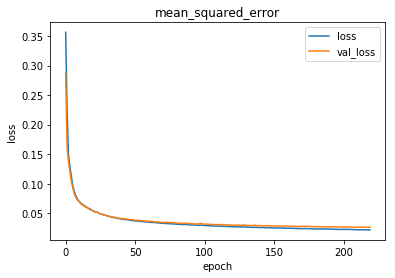

In [2]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("mean_squared_error")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'], loc='upper right')
plt.show()


Test Images
Reconstruction of Test Images
[[1.0138218 ]
 [1.03817   ]
 [1.0560275 ]
 [1.0258689 ]
 [1.0185109 ]
 [1.0462677 ]
 [1.0409337 ]
 [1.0218318 ]
 [1.030578  ]
 [1.0515918 ]
 [1.0538691 ]
 [1.0349255 ]
 [1.0497073 ]
 [1.039431  ]
 [1.0328335 ]
 [1.0096842 ]
 [1.0273975 ]
 [1.0251127 ]
 [1.0253417 ]
 [1.0069604 ]
 [1.0112205 ]
 [1.0143678 ]
 [1.0176758 ]
 [1.0103033 ]
 [1.0199103 ]
 [1.0241307 ]
 [1.0282835 ]
 [1.0363542 ]
 [1.0389285 ]
 [1.0336882 ]
 [1.0314704 ]
 [1.0357486 ]
 [1.021343  ]
 [1.0317858 ]
 [1.0324574 ]
 [1.0412421 ]
 [1.0207771 ]
 [1.0171545 ]
 [1.0149562 ]
 [1.022003  ]
 [0.99912393]
 [0.98822105]
 [0.9705791 ]
 [0.9773229 ]
 [0.96538484]
 [0.95557594]
 [0.95976955]
 [0.9707241 ]
 [0.9521258 ]
 [0.940942  ]
 [0.9490785 ]
 [0.9655915 ]
 [0.9660913 ]
 [0.9707706 ]
 [0.9835866 ]
 [1.0162233 ]
 [1.0137615 ]
 [1.0206959 ]
 [1.0391842 ]
 [1.0375901 ]
 [1.0285099 ]
 [1.0185311 ]
 [1.020023  ]
 [1.02086   ]
 [1.0167567 ]
 [1.0063878 ]
 [0.99850863]
 [0.9918397 ]
 [0.97

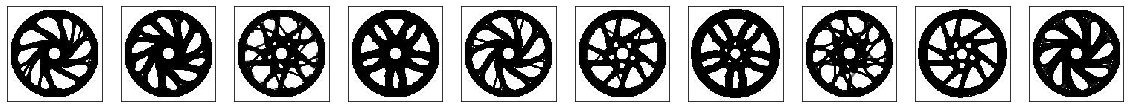

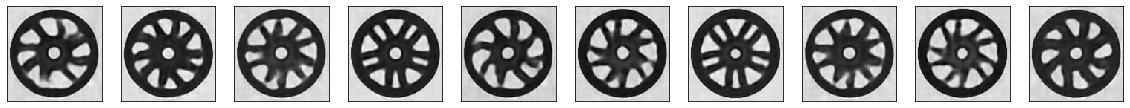

In [3]:

#--------------------
from PIL import Image
from keras.models import load_model
import os, glob, sys, numpy as np
import matplotlib.pyplot as plt
#load test image


#load test image

caltech_dir = './dataset/test'


image_w = 128
image_h = 128


np.random.seed(7)


X = []
y = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("L")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)
    filenames.append(f)
    X.append(data)
    
    file_token=filenames[i].split("_")[1]  
    
    


X = np.array(X)
X = X.reshape(X.shape[0], image_w, image_h, 1)
X = X.astype('float32') / 255

model = load_model('./model/con_autoencoder.model')


# make a prediction

pred = model.predict(X)


n=10
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    ax=plt.subplot(2, n, i+1)
    plt.imshow(X[i].reshape(128,128), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    ax=plt.subplot(2, n, i+1)
    plt.imshow(pred[i].reshape(128,128), cmap='gray')
    print(pred[0,:,0])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


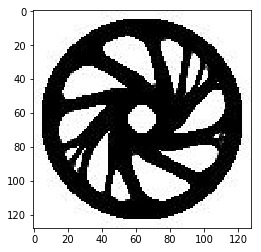

해당 ./dataset/test/110_0.0005_0.2.jpg 	  이미지의 y값은 [[[1.01382]
  [1.02334]
  [1.03531]
  ...
  [1.02267]
  [1.02491]
  [0.97494]]

 [[1.03817]
  [0.98559]
  [1.03050]
  ...
  [0.97310]
  [0.99052]
  [1.03872]]

 [[1.05603]
  [1.01262]
  [1.02548]
  ...
  [0.99463]
  [1.00757]
  [0.95503]]

 ...

 [[1.01124]
  [0.99946]
  [1.04131]
  ...
  [1.03866]
  [1.01565]
  [1.01229]]

 [[1.02014]
  [0.99962]
  [1.02384]
  ...
  [1.01113]
  [1.00689]
  [1.03440]]

 [[1.00721]
  [1.01116]
  [1.02134]
  ...
  [1.07203]
  [1.05650]
  [1.01893]]]값으로 예측됩니다.


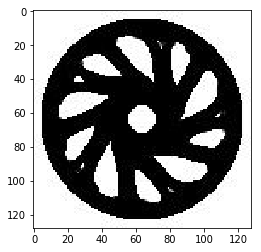

해당 ./dataset/test/591_0.001_0.2.jpg 	  이미지의 y값은 [[[0.99629]
  [1.01560]
  [1.02830]
  ...
  [1.04346]
  [1.04611]
  [0.99355]]

 [[1.02611]
  [0.98498]
  [1.03261]
  ...
  [1.00390]
  [1.01707]
  [1.05574]]

 [[1.03650]
  [1.00118]
  [1.01621]
  ...
  [1.02691]
  [1.02852]
  [0.96564]]

 ...

 [[0.99483]
  [0.98260]
  [1.02577]
  ...
  [1.04663]
  [1.02166]
  [1.02836]]

 [[1.00076]
  [0.98841]
  [1.01601]
  ...
  [1.00683]
  [1.00022]
  [1.04223]]

 [[0.99318]
  [1.00524]
  [1.02455]
  ...
  [1.07095]
  [1.05721]
  [1.02480]]]값으로 예측됩니다.


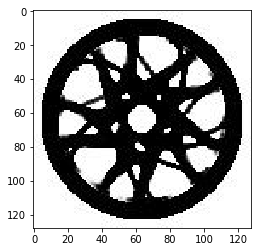

해당 ./dataset/test/110_0.01_0.2.jpg 	  이미지의 y값은 [[[0.99653]
  [1.00686]
  [1.02071]
  ...
  [1.02671]
  [1.02968]
  [0.98482]]

 [[1.01627]
  [0.96559]
  [1.01200]
  ...
  [0.97364]
  [0.99419]
  [1.04300]]

 [[1.03238]
  [0.98989]
  [1.00488]
  ...
  [0.99633]
  [1.01204]
  [0.95904]]

 ...

 [[0.99643]
  [0.98067]
  [1.02392]
  ...
  [1.04142]
  [1.01515]
  [1.01257]]

 [[1.01111]
  [0.98969]
  [1.01316]
  ...
  [1.00964]
  [1.00503]
  [1.03576]]

 [[1.00048]
  [1.00400]
  [1.01441]
  ...
  [1.06714]
  [1.05183]
  [1.01732]]]값으로 예측됩니다.


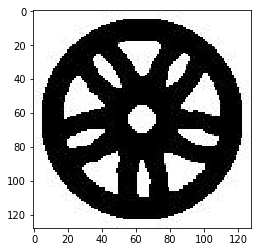

해당 ./dataset/test/591_0.05_0.2.jpg 	  이미지의 y값은 [[[1.00055]
  [1.02282]
  [1.03965]
  ...
  [1.03003]
  [1.03637]
  [0.98837]]

 [[1.02275]
  [0.98527]
  [1.03299]
  ...
  [0.98655]
  [1.00111]
  [1.04622]]

 [[1.02601]
  [0.99544]
  [1.01202]
  ...
  [1.00856]
  [1.01368]
  [0.95760]]

 ...

 [[1.00230]
  [0.99565]
  [1.03570]
  ...
  [1.02593]
  [1.00486]
  [1.00975]]

 [[1.01445]
  [1.00290]
  [1.02187]
  ...
  [0.98607]
  [0.98530]
  [1.02500]]

 [[1.00334]
  [1.01129]
  [1.02074]
  ...
  [1.04455]
  [1.03263]
  [1.00138]]]값으로 예측됩니다.


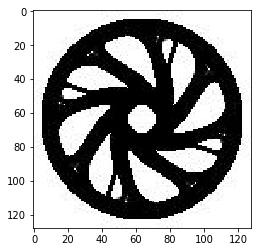

해당 ./dataset/test/110_0_0.2.jpg 	  이미지의 y값은 [[[1.01483]
  [1.02658]
  [1.03912]
  ...
  [1.04063]
  [1.03757]
  [0.98242]]

 [[1.04095]
  [0.99210]
  [1.04042]
  ...
  [1.00311]
  [1.01032]
  [1.04973]]

 [[1.05691]
  [1.01708]
  [1.03606]
  ...
  [1.02486]
  [1.02663]
  [0.96661]]

 ...

 [[0.99191]
  [0.98575]
  [1.03093]
  ...
  [1.02484]
  [1.00049]
  [0.99524]]

 [[0.99614]
  [0.98236]
  [1.01110]
  ...
  [0.99283]
  [0.98488]
  [1.01106]]

 [[0.98740]
  [0.99531]
  [1.01313]
  ...
  [1.05337]
  [1.03514]
  [0.99548]]]값으로 예측됩니다.


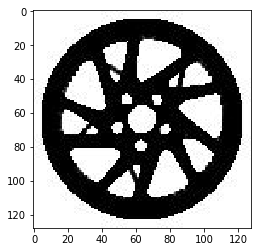

해당 ./dataset/test/110_0.05_0.2.jpg 	  이미지의 y값은 [[[0.99093]
  [1.00375]
  [1.01740]
  ...
  [1.03232]
  [1.04009]
  [0.99431]]

 [[1.01347]
  [0.96420]
  [1.01078]
  ...
  [0.98332]
  [1.00476]
  [1.05486]]

 [[1.02558]
  [0.98526]
  [1.00022]
  ...
  [1.00818]
  [1.02274]
  [0.97090]]

 ...

 [[1.00225]
  [0.98433]
  [1.01056]
  ...
  [1.01767]
  [1.00114]
  [1.00597]]

 [[1.01808]
  [0.99431]
  [0.99924]
  ...
  [0.98367]
  [0.98856]
  [1.02763]]

 [[1.00028]
  [1.00122]
  [1.00179]
  ...
  [1.04155]
  [1.02933]
  [1.00273]]]값으로 예측됩니다.


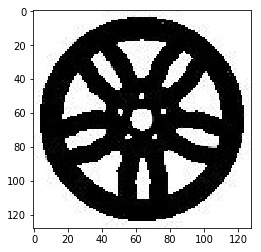

해당 ./dataset/test/591_0_0.0.jpg 	  이미지의 y값은 [[[0.99426]
  [1.01576]
  [1.03367]
  ...
  [1.03770]
  [1.03944]
  [0.98753]]

 [[1.01708]
  [0.97792]
  [1.02406]
  ...
  [0.99385]
  [1.00530]
  [1.04756]]

 [[1.02212]
  [0.98945]
  [1.00424]
  ...
  [1.01286]
  [1.01559]
  [0.95763]]

 ...

 [[0.98703]
  [0.98185]
  [1.02190]
  ...
  [1.01861]
  [0.99930]
  [1.00484]]

 [[1.00356]
  [0.99286]
  [1.01026]
  ...
  [0.97981]
  [0.97938]
  [1.02029]]

 [[0.99121]
  [0.99869]
  [1.00496]
  ...
  [1.03890]
  [1.02732]
  [0.99643]]]값으로 예측됩니다.


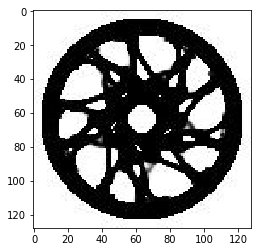

해당 ./dataset/test/110_0.005_0.2.jpg 	  이미지의 y값은 [[[1.00206]
  [1.01266]
  [1.02581]
  ...
  [1.02592]
  [1.02860]
  [0.98534]]

 [[1.02487]
  [0.97530]
  [1.01915]
  ...
  [0.97475]
  [0.99453]
  [1.04242]]

 [[1.04254]
  [1.00011]
  [1.01125]
  ...
  [0.99839]
  [1.01352]
  [0.95998]]

 ...

 [[0.99181]
  [0.97506]
  [1.02140]
  ...
  [1.04065]
  [1.01688]
  [1.01675]]

 [[1.00403]
  [0.98334]
  [1.01265]
  ...
  [1.01314]
  [1.00980]
  [1.04131]]

 [[0.99645]
  [1.00037]
  [1.01695]
  ...
  [1.07185]
  [1.05771]
  [1.02358]]]값으로 예측됩니다.


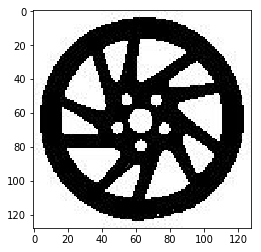

해당 ./dataset/test/110_0_0.jpg 	  이미지의 y값은 [[[0.98699]
  [1.00003]
  [1.01291]
  ...
  [1.03514]
  [1.03860]
  [0.98884]]

 [[1.01201]
  [0.96155]
  [1.00580]
  ...
  [0.98675]
  [1.00604]
  [1.05179]]

 [[1.02356]
  [0.98116]
  [0.99449]
  ...
  [1.00931]
  [1.02223]
  [0.96614]]

 ...

 [[1.00438]
  [0.99005]
  [1.02154]
  ...
  [1.01552]
  [0.99887]
  [1.00250]]

 [[1.01836]
  [0.99886]
  [1.01034]
  ...
  [0.97978]
  [0.98345]
  [1.02141]]

 [[1.00307]
  [1.00609]
  [1.01010]
  ...
  [1.04191]
  [1.02846]
  [0.99785]]]값으로 예측됩니다.


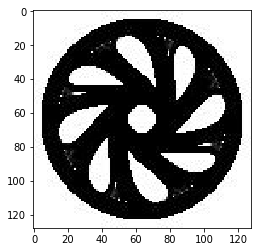

해당 ./dataset/test/591_0_0.2.jpg 	  이미지의 y값은 [[[1.02796]
  [1.04149]
  [1.05358]
  ...
  [1.01789]
  [1.02000]
  [0.96688]]

 [[1.04702]
  [1.00036]
  [1.05340]
  ...
  [0.97869]
  [0.99166]
  [1.03525]]

 [[1.05761]
  [1.02194]
  [1.04678]
  ...
  [0.99792]
  [1.00709]
  [0.95197]]

 ...

 [[1.00624]
  [0.99744]
  [1.04129]
  ...
  [1.02325]
  [0.99894]
  [0.99326]]

 [[1.00924]
  [0.99242]
  [1.02065]
  ...
  [0.98815]
  [0.97765]
  [1.00363]]

 [[1.00189]
  [1.00773]
  [1.02530]
  ...
  [1.05140]
  [1.03162]
  [0.98886]]]값으로 예측됩니다.


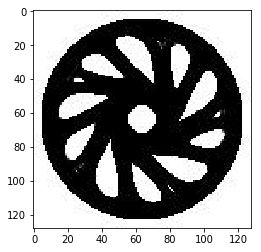

해당 ./dataset/test/591_0.0005_0.2.jpg 	  이미지의 y값은 [[[0.99415]
  [1.01193]
  [1.02361]
  ...
  [1.04027]
  [1.04302]
  [0.99000]]

 [[1.02420]
  [0.98091]
  [1.02832]
  ...
  [1.00038]
  [1.01442]
  [1.05212]]

 [[1.03406]
  [0.99760]
  [1.01171]
  ...
  [1.02322]
  [1.02572]
  [0.96200]]

 ...

 [[0.99157]
  [0.97968]
  [1.01883]
  ...
  [1.04513]
  [1.02021]
  [1.02508]]

 [[0.99809]
  [0.98592]
  [1.00895]
  ...
  [1.00541]
  [0.99861]
  [1.03867]]

 [[0.98865]
  [0.99961]
  [1.01674]
  ...
  [1.06872]
  [1.05472]
  [1.02132]]]값으로 예측됩니다.


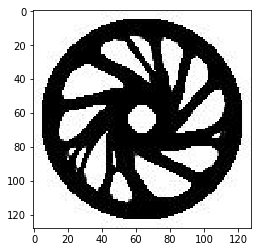

해당 ./dataset/test/110_0.001_0.2.jpg 	  이미지의 y값은 [[[1.01021]
  [1.02051]
  [1.03169]
  ...
  [1.02335]
  [1.02289]
  [0.97637]]

 [[1.03637]
  [0.98316]
  [1.02530]
  ...
  [0.96814]
  [0.98618]
  [1.03469]]

 [[1.05436]
  [1.00947]
  [1.01853]
  ...
  [0.98983]
  [1.00323]
  [0.95260]]

 ...

 [[1.01884]
  [1.00488]
  [1.04622]
  ...
  [1.04067]
  [1.01612]
  [1.01108]]

 [[1.02831]
  [1.00701]
  [1.02988]
  ...
  [1.01289]
  [1.00758]
  [1.03438]]

 [[1.01513]
  [1.01801]
  [1.02725]
  ...
  [1.07275]
  [1.05651]
  [1.01818]]]값으로 예측됩니다.


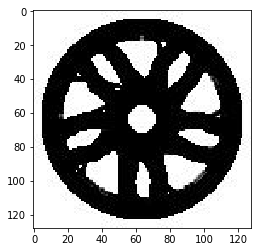

해당 ./dataset/test/591_0.01_0.2.jpg 	  이미지의 y값은 [[[1.00291]
  [1.02654]
  [1.04335]
  ...
  [1.02878]
  [1.03415]
  [0.98594]]

 [[1.02679]
  [0.99113]
  [1.03909]
  ...
  [0.98522]
  [0.99930]
  [1.04353]]

 [[1.02980]
  [1.00019]
  [1.01716]
  ...
  [1.00658]
  [1.01107]
  [0.95476]]

 ...

 [[0.99868]
  [0.99129]
  [1.03277]
  ...
  [1.02365]
  [1.00177]
  [1.00737]]

 [[1.00995]
  [0.99711]
  [1.01765]
  ...
  [0.98446]
  [0.98156]
  [1.02181]]

 [[0.99947]
  [1.00633]
  [1.01613]
  ...
  [1.04129]
  [1.02893]
  [0.99835]]]값으로 예측됩니다.


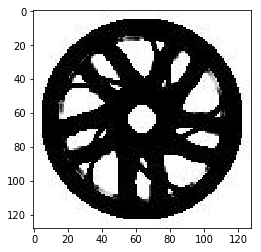

해당 ./dataset/test/591_0.005_0.2.jpg 	  이미지의 y값은 [[[1.00539]
  [1.03014]
  [1.04690]
  ...
  [1.03346]
  [1.03856]
  [0.98946]]

 [[1.03162]
  [0.99623]
  [1.04432]
  ...
  [0.99231]
  [1.00547]
  [1.04832]]

 [[1.03763]
  [1.00929]
  [1.02644]
  ...
  [1.01438]
  [1.01636]
  [0.95837]]

 ...

 [[0.99359]
  [0.98346]
  [1.02444]
  ...
  [1.03567]
  [1.01290]
  [1.01917]]

 [[1.00558]
  [0.99028]
  [1.01068]
  ...
  [0.99758]
  [0.99323]
  [1.03409]]

 [[0.99677]
  [1.00479]
  [1.01575]
  ...
  [1.05751]
  [1.04491]
  [1.01417]]]값으로 예측됩니다.


In [5]:
# make a prediction
predictions = model.predict(X)

np.set_printoptions(formatter={'float': lambda x: "{0:0.5f}".format(x)})


cnt = 0
for i in predictions:
    img = load_img(filenames[cnt],False,target_size=(128,128))
    plt.imshow(img)
    plt.show()
    #x = img_to_array(img)
    #x = np.expand_dims(x, axis=0)
    
    print("해당 " + filenames[cnt] + " \t"+  "  이미지의 y값은 " + str(i) + "값으로 예측됩니다.")
    cnt += 1
